In [1]:
import pandas as pd
import numpy as np
import os
import cv2 # 이미지 처리
from PIL import Image # 이미지 처리 (선택적)
import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화 (matplotlib 기반)

# Jupyter Notebook/Google Colab에서 plot이 보이도록 설정
%matplotlib inline

# 데이터 경로 설정 (이전 코드에서 사용했던 경로)
data_path = 'train.csv'
df = pd.read_csv(data_path)
base_image_dir = 'colored_images' # 이미지가 실제로 저장된 디렉토리

# 레이블 매핑 (이전 코드에서 사용했던 매핑)
label_mapping = {
    'No_DR':0,
    'Mild':1,
    'Moderate':2,
    'Severe':3,
    'Proliferate_DR':4
}
# 역매핑도 준비해두면 시각화에 편리합니다.
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

print(f"Loaded DataFrame head:\n{df.head()}")
print(f"Total images in DataFrame: {len(df)}")

Loaded DataFrame head:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Total images in DataFrame: 3662


**이미지 형식, 해상도, 크기 분포 확인**


Missing images count: 0

--- Image Resolution Distribution ---
224x224    3662
Name: count, dtype: int64


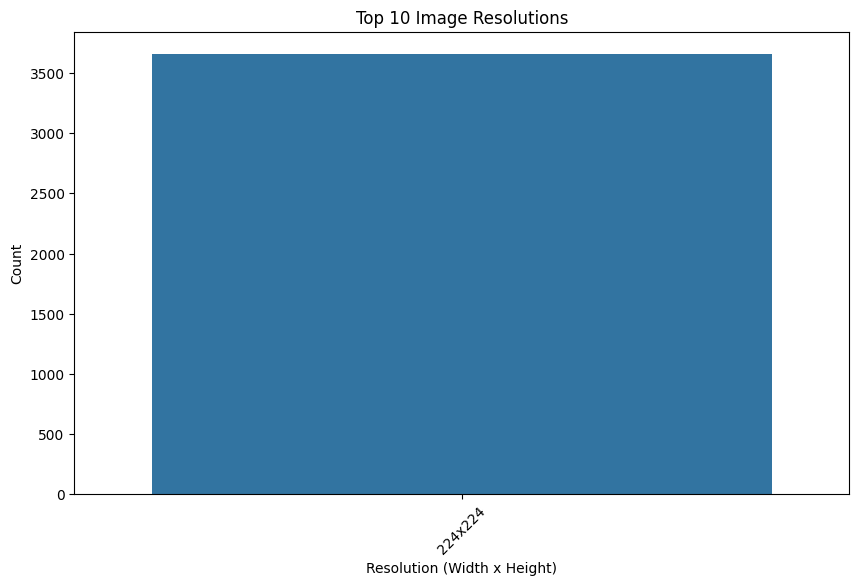


--- Image Channel Distribution ---
3    3662
Name: count, dtype: int64

--- Image Format Distribution ---
.png    3662
Name: count, dtype: int64


In [2]:
image_resolutions = []
image_channels = []
image_formats = [] # 이미지 파일 확장자

# CSV 파일의 id_code와 diagnosis 정보를 사용하지만,
# 실제 이미지는 base_image_dir/diagnosis_folder/id_code.png 경로에 있다고 가정합니다.
# df에 diagnosis_name (예: 'No_DR')이 직접 있다고 가정하고 진행합니다.
# 만약 df에 diagnosis_name이 없고 diagnosis (0,1,2,3,4)만 있다면
# df['diagnosis_name'] = df['diagnosis'].map(reverse_label_mapping) 와 같이 매핑을 먼저 해야합니다.

# 예시: df에 'diagnosis' (0-4) 컬럼이 있고, 이를 'diagnosis_name'으로 변환
if 'diagnosis_name' not in df.columns:
    df['diagnosis_name'] = df['diagnosis'].map(reverse_label_mapping)


print("Collecting image metadata (this might take a while for large datasets)...")
missing_images = []
for index, row in df.iterrows():
    # 이미지 파일 경로 구성 (실제 데이터셋 구조에 따라 조정 필요)
    # colored_images/No_DR/10003_left.png 와 같은 경로를 따른다고 가정
    img_filename = row['id_code'] + '.png'
    # diagnosis_name을 사용하여 해당 폴더를 찾습니다.
    img_path = os.path.join(base_image_dir, row['diagnosis_name'], img_filename)

    if os.path.exists(img_path):
        try:
            # OpenCV로 이미지 로드 (RGB 채널 순서로 읽기 위해 cv2.IMREAD_COLOR 사용)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                h, w, c = img.shape
                image_resolutions.append(f"{w}x{h}") # 가로x세로
                image_channels.append(c)
                image_formats.append(os.path.splitext(img_path)[1]) # .png, .jpg 등

            else:
                print(f"Warning: Could not read image at {img_path}. It might be corrupted.")
                missing_images.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            missing_images.append(img_path)
    else:
        # print(f"Image not found: {img_path}") # 너무 많으면 주석 처리
        missing_images.append(img_path)


print(f"\nMissing images count: {len(missing_images)}")
if len(missing_images) > 0:
    print(f"Sample missing images: {missing_images[:5]}") # 누락된 이미지 샘플 확인

# 해상도 분포
print("\n--- Image Resolution Distribution ---")
resolution_counts = pd.Series(image_resolutions).value_counts()
print(resolution_counts)
# 가장 흔한 해상도 몇 개 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=resolution_counts.index[:10], y=resolution_counts.values[:10])
plt.title('Top 10 Image Resolutions')
plt.xlabel('Resolution (Width x Height)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 채널 수 분포
print("\n--- Image Channel Distribution ---")
channel_counts = pd.Series(image_channels).value_counts()
print(channel_counts)
# 대부분 3 (컬러 이미지)일 것입니다.

# 이미지 형식 분포
print("\n--- Image Format Distribution ---")
format_counts = pd.Series(image_formats).value_counts()
print(format_counts)

**클래스별 이미지 수 확인**


--- Class Distribution ---
diagnosis_name
Mild               370
Moderate           999
No_DR             1805
Proliferate_DR     295
Severe             193
Name: count, dtype: int64


C:\Users\asia\AppData\Local\Temp\ipykernel_21880\1951638822.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


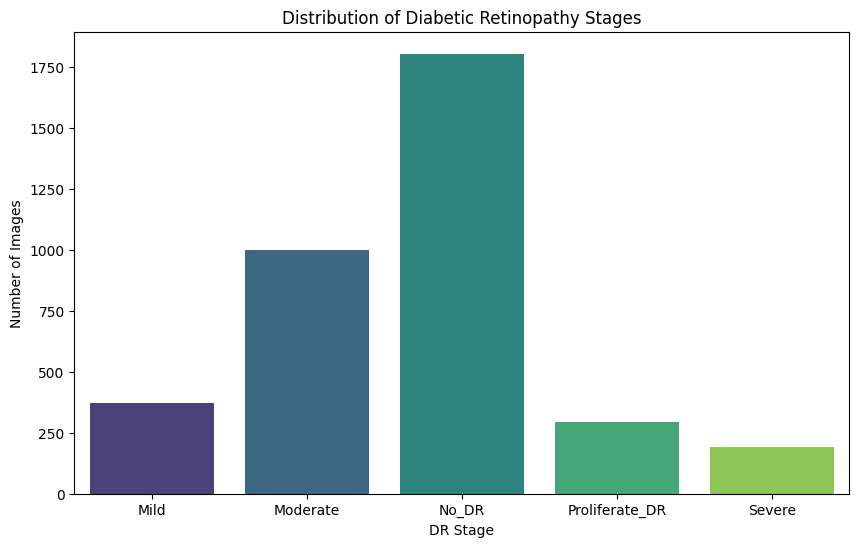


--- Class Distribution (Percentage) ---
diagnosis_name
Mild              10.10
Moderate          27.28
No_DR             49.29
Proliferate_DR     8.06
Severe             5.27
Name: count, dtype: float64


In [3]:
print("\n--- Class Distribution ---")
class_counts = df['diagnosis_name'].value_counts().sort_index() # 진단명으로 정렬
print(class_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Diabetic Retinopathy Stages')
plt.xlabel('DR Stage')
plt.ylabel('Number of Images')
plt.show()

# 비율 계산
total_images_in_df = len(df)
print("\n--- Class Distribution (Percentage) ---")
print((class_counts / total_images_in_df * 100).round(2))

**각 단계별 특징 및 데이터의 품질 시각적으로 확인**

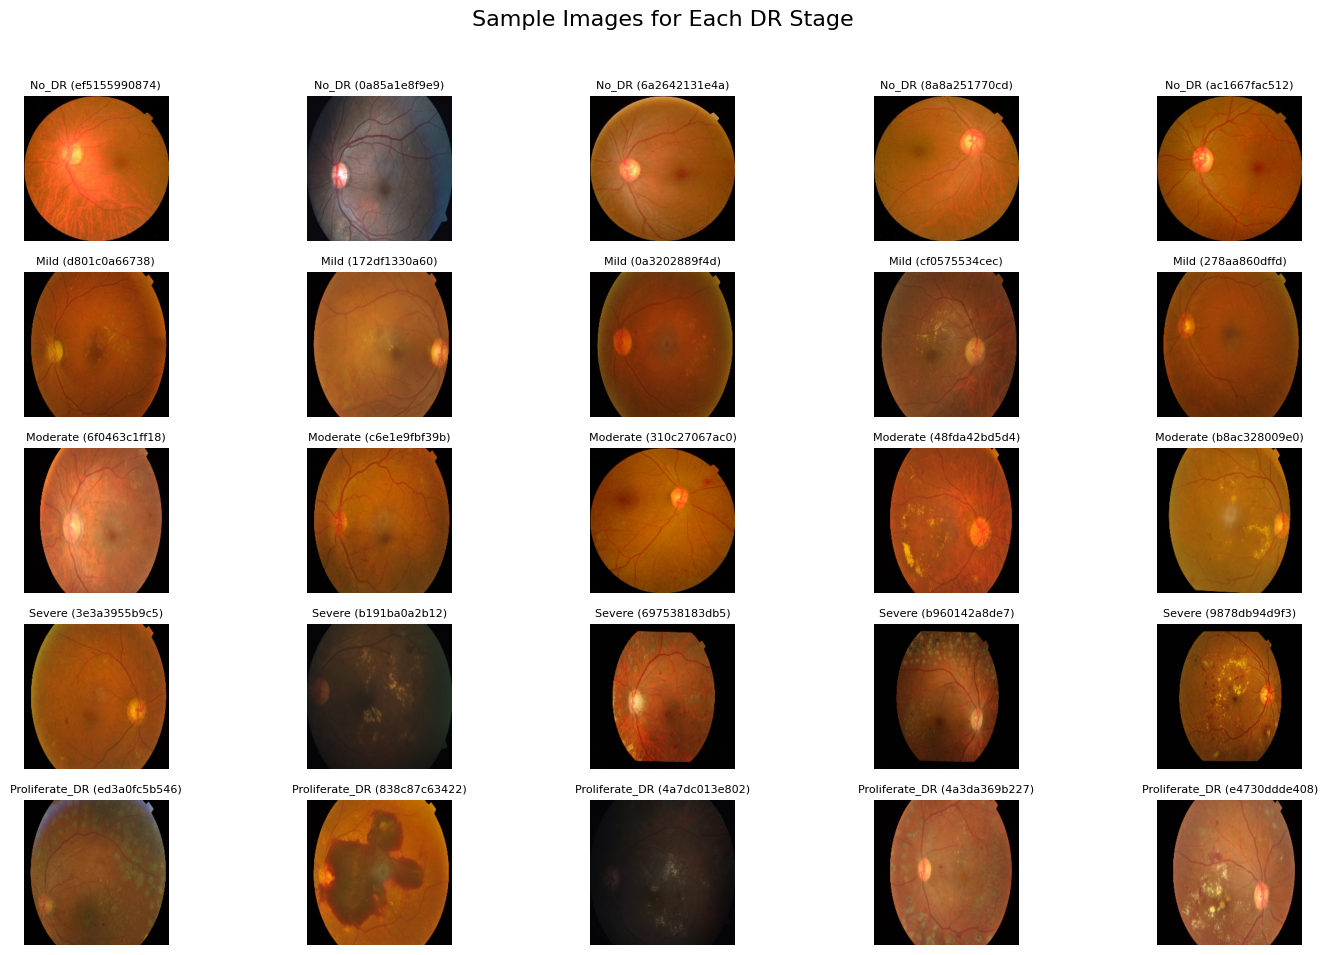


--- Checking Data Quality (Visual Inspection) ---
While viewing sample images from the previous step, pay attention to:
1. Bluriness or poor focus.
2. Uneven lighting or glare.
3. Dust, smudges, or other artifacts on the lens/image.
4. Areas of the retina that are not clearly visible.
5. Compression artifacts if images are heavily compressed (e.g., JPEG with low quality).

If significant quality issues are present, consider:
 - Applying additional pre-processing steps (e.g., contrast enhancement, noise reduction).
 - Filtering out extremely low-quality images if their number is small.


In [4]:
# 각 클래스별로 몇 개의 샘플 이미지를 볼 것인지 설정
samples_per_class = 5

plt.figure(figsize=(15, 10)) # 전체 플롯 크기 조정

for label_name, label_num in label_mapping.items():
    # 해당 진단명에 해당하는 이미지들 필터링
    class_df = df[df['diagnosis_name'] == label_name]

    # 샘플 이미지들을 무작위로 선택
    sample_ids = class_df['id_code'].sample(min(samples_per_class, len(class_df)), random_state=42)

    for i, img_id in enumerate(sample_ids):
        # subplot 위치 계산
        # 5개 클래스 * samples_per_class + (현재 인덱스 + 1)
        # 예: No_DR (0번 클래스)의 첫 번째 이미지는 (0 * samples_per_class + 1) = 1번 서브플롯
        # Mild (1번 클래스)의 첫 번째 이미지는 (1 * samples_per_class + 1) = 4번 서브플롯
        plot_idx = label_num * samples_per_class + (i + 1)
        plt.subplot(len(label_mapping), samples_per_class, plot_idx)

        img_filename = img_id + '.png'
        img_path = os.path.join(base_image_dir, label_name, img_filename)

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV는 BGR, Matplotlib은 RGB
                plt.imshow(img)
                plt.title(f"{label_name} ({img_id})", fontsize=8)
                plt.axis('off')
            else:
                plt.title(f"Error loading {label_name} {img_id}")
                plt.axis('off')
        else:
            plt.title(f"Missing {label_name} {img_id}")
            plt.axis('off')

plt.suptitle('Sample Images for Each DR Stage', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 제목 공간 확보
plt.show()

#원본 데이터의 품질(노이즈, 아티팩트 등)
print("\n--- Checking Data Quality (Visual Inspection) ---")
print("While viewing sample images from the previous step, pay attention to:")
print("1. Bluriness or poor focus.")
print("2. Uneven lighting or glare.")
print("3. Dust, smudges, or other artifacts on the lens/image.")
print("4. Areas of the retina that are not clearly visible.")
print("5. Compression artifacts if images are heavily compressed (e.g., JPEG with low quality).")
print("\nIf significant quality issues are present, consider:")
print(" - Applying additional pre-processing steps (e.g., contrast enhancement, noise reduction).")
print(" - Filtering out extremely low-quality images if their number is small.")

**이미지 전처리**

In [36]:
from tensorflow.keras.utils import to_categorical

# --- STEP 1: 고급 이미지 전처리 함수 정의 ---

# 모델의 입력 이미지 크기를 정의합니다. (224x224는 흔히 사용되는 크기)
IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
NUM_CLASSES = len(label_mapping) # 5개 클래스

# 단일 이미지를 전처리하는 함수
def preprocess_image_advanced(image_path, img_size=IMG_SIZE):
    image = cv2.imread(image_path)
    if image is None:
        # 이미지 로드 실패 시 None 반환. 추후 스킵 처리.
        print(f"Warning: Could not read image at {image_path}. It might be corrupted or missing.")
        return None

    # 컬러 이미지를 YCrCb 색 공간으로 변환합니다. (Y: 밝기, Cr: 적색-녹색 차이, Cb: 청색-노란색 차이)
    # CLAHE는 Y(밝기) 채널에만 적용하여 명암비를 개선합니다.
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    # CLAHE 객체 생성:
    # clipLimit: 대비 증폭을 제한하여 노이즈 과도 증폭을 방지합니다. 2.0이 일반적인 값입니다.
    # tileGridSize: 이미지를 나눌 그리드 크기. 작은 타일은 더 지역적인 대비 조절에 좋습니다.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    # Y 채널에 CLAHE 적용
    img_ycrcb[:, :, 0] = clahe.apply(img_ycrcb[:, :, 0])
    
    # YCrCb를 다시 BGR(OpenCV 기본 색 공간)로 변환
    image = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2BGR)

    # 이미지 크기 조정: 모든 이미지를 모델 입력에 맞는 동일한 크기로 리사이즈
    image = cv2.resize(image, img_size)

    # 픽셀 값 정규화: 0-255 범위의 픽셀 값을 0-1.0 범위로 변환합니다.
    # 이는 신경망이 데이터를 효율적으로 처리하는 데 중요합니다.
    image = image / 255.0

    return image

# DataFrame의 정보를 바탕으로 전체 이미지 데이터셋을 전처리하여 로드하는 함수
def load_and_preprocess_data(df, base_image_dir, label_mapping, img_size=IMG_SIZE):
    images = []
    labels = []
    # 어떤 'id_code'의 이미지가 성공적으로 로드되고 전처리되었는지 추적하기 위한 리스트 (선택적)
    processed_image_ids = []

    print(f"\n[STEP 1] Starting image loading and advanced preprocessing for {len(df)} entries...")
    
    # DataFrame의 각 행을 반복하면서 이미지 로드 및 전처리
    for index, row in df.iterrows():
        label_name = row['diagnosis_name'] # 'diagnosis_name' 컬럼을 사용하여 진단명 얻기
        label_num = label_mapping[label_name] # 진단명에 해당하는 숫자 레이블 얻기

        img_filename = row['id_code'] + '.png' # 이미지 파일 이름 (예: 10003_left.png)
        # 이미지의 실제 파일 시스템 경로 구성 (예: colored_images/No_DR/10003_left.png)
        img_path = os.path.join(base_image_dir, label_name, img_filename)

        if os.path.exists(img_path): # 파일이 실제로 존재하는지 확인
            preprocessed_img = preprocess_image_advanced(img_path, img_size)
            if preprocessed_img is not None: # 이미지 전처리가 성공했으면 리스트에 추가
                images.append(preprocessed_img)
                labels.append(label_num)
                processed_image_ids.append(row['id_code'])
            # 만약 preprocess_image_advanced에서 None이 반환되면 이미 경고 메시지가 출력됩니다.
        else:
            # 파일이 없는 경우 건너뜁니다. (데이터 누락이 있다면 중요)
            # print(f"Skipping missing image: {img_path}") # 필요하다면 이 줄의 주석을 해제하세요.
            pass # 너무 많은 메시지 출력을 피하기 위해 기본적으로는 출력하지 않습니다.
            
    images = np.array(images) # 이미지 리스트를 NumPy 배열로 변환
    labels = np.array(labels) # 레이블 리스트를 NumPy 배열로 변환
    
    # 레이블을 원-핫 인코딩으로 변환 (예: 0 -> [1,0,0,0,0], 1 -> [0,1,0,0,0] 등)
    # 이는 다중 클래스 분류 모델의 출력 레이어 형태와 일치시킵니다.
    labels_one_hot = to_categorical(labels, num_classes=NUM_CLASSES)

    print(f"[STEP 1] Finished loading and preprocessing. Loaded {len(images)} images.")
    return images, labels_one_hot, processed_image_ids

**전처리된 데이터 로드 및 확인**

In [37]:
# --- STEP 2: 전처리된 데이터 로드 및 확인 ---

# load_and_preprocess_data 함수를 호출하여 images와 labels를 얻습니다.
# 이 함수는 CLAHE가 적용되고, 리사이즈 및 정규화된 이미지 배열을 반환합니다.
images, labels_one_hot, loaded_image_ids = load_and_preprocess_data(df, base_image_dir, label_mapping, IMG_SIZE)

print(f"\nPreprocessed images shape: {images.shape}")
print(f"One-hot encoded labels shape: {labels_one_hot.shape}")
print(f"Number of successfully loaded images: {len(loaded_image_ids)}")


[STEP 1] Starting image loading and advanced preprocessing for 3662 entries...
[STEP 1] Finished loading and preprocessing. Loaded 3662 images.

Preprocessed images shape: (3662, 224, 224, 3)
One-hot encoded labels shape: (3662, 5)
Number of successfully loaded images: 3662


**학습/검증 데이터 분할**

In [38]:
# --- STEP 3: 학습/검증 데이터 분할 (Stratified Split 적용) ---

# Stratify 옵션을 사용하기 위해 원-핫 인코딩된 레이블(labels_one_hot)에서 원래의 숫자 레이블을 추출합니다.
# np.argmax(axis=1)는 원-핫 벡터에서 1인 위치의 인덱스를 반환하여 숫자 레이블로 변환합니다.
labels_for_stratify = np.argmax(labels_one_hot, axis=1)

# 데이터를 학습 세트와 검증 세트로 분할합니다.
# test_size=0.2는 전체 데이터의 20%를 검증 세트로 사용한다는 의미입니다.
# random_state는 분할의 재현성을 위해 고정합니다. (항상 동일한 결과 얻기 위함)
# stratify=labels_for_stratify 가 핵심입니다: 클래스 분포가 유지되도록 분할합니다.
X_train, X_val, y_train, y_val = train_test_split(
    images,              # 전처리된 이미지 데이터
    labels_one_hot,      # 원-핫 인코딩된 레이블
    test_size=0.2,       # 검증 세트 비율 (예: 20%)
    random_state=42,     # 시드 고정
    stratify=labels_for_stratify # 클래스 불균형 처리
)

print(f"\n[STEP 3] Data split complete.")
print(f"Training data shape (X_train): {X_train.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Validation data shape (X_val): {X_val.shape}")
print(f"Validation labels shape (y_val): {y_val.shape}")


[STEP 3] Data split complete.
Training data shape (X_train): (2929, 224, 224, 3)
Training labels shape (y_train): (2929, 5)
Validation data shape (X_val): (733, 224, 224, 3)
Validation labels shape (y_val): (733, 5)



[STEP 4] Verifying Class Distribution in Training and Validation Sets...

--- Training Set Class Distribution ---
Mild               296
Moderate           799
No_DR             1444
Proliferate_DR     236
Severe             154
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_4048\596002485.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_class_counts.index, y=train_class_counts.values, palette='viridis')


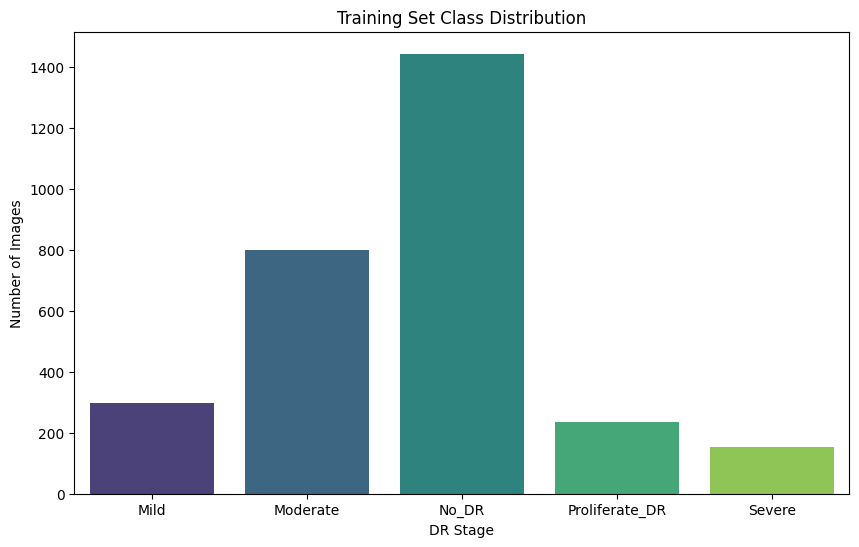


--- Validation Set Class Distribution ---
Mild               74
Moderate          200
No_DR             361
Proliferate_DR     59
Severe             39
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_4048\596002485.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_class_counts.index, y=val_class_counts.values, palette='viridis')


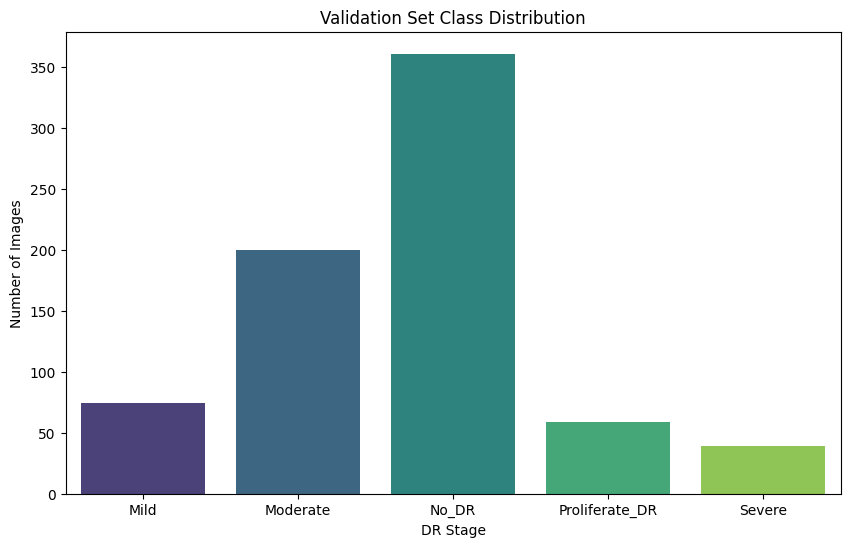

[STEP 4] Class distribution verification complete. The distributions should be similar to the original dataset.


In [39]:
# --- STEP 4: 분할된 데이터의 클래스 분포 확인 ---

print("\n[STEP 4] Verifying Class Distribution in Training and Validation Sets...")

# 학습 세트의 클래스 분포 확인
train_class_counts = pd.Series(np.argmax(y_train, axis=1)).map(reverse_label_mapping).value_counts().sort_index()
print("\n--- Training Set Class Distribution ---")
print(train_class_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=train_class_counts.index, y=train_class_counts.values, palette='viridis')
plt.title('Training Set Class Distribution')
plt.xlabel('DR Stage')
plt.ylabel('Number of Images')
plt.show()

# 검증 세트의 클래스 분포 확인
val_class_counts = pd.Series(np.argmax(y_val, axis=1)).map(reverse_label_mapping).value_counts().sort_index()
print("\n--- Validation Set Class Distribution ---")
print(val_class_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=val_class_counts.index, y=val_class_counts.values, palette='viridis')
plt.title('Validation Set Class Distribution')
plt.xlabel('DR Stage')
plt.ylabel('Number of Images')
plt.show()

print("[STEP 4] Class distribution verification complete. The distributions should be similar to the original dataset.")

**데이터 증강**

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- STEP 5: 데이터 증강 (Data Augmentation) 설정 ---

print("\n[STEP 5] Setting up Data Augmentation for Training Data...")

# ImageDataGenerator 객체를 생성하여 데이터 증강 파라미터를 정의합니다.
# 이미지 픽셀 값은 이미 0-1로 정규화되었으므로 rescale 파라미터는 여기서는 사용하지 않습니다.
train_datagen = ImageDataGenerator(
    rotation_range=20,        # 이미지를 -20도에서 +20도 사이로 랜덤하게 회전합니다. (단위: 도)
    width_shift_range=0.1,    # 이미지 가로 너비의 10% 이내로 랜덤하게 좌우 이동시킵니다. (비율)
    height_shift_range=0.1,   # 이미지 세로 높이의 10% 이내로 랜덤하게 상하 이동시킵니다. (비율)
    shear_range=0.2,          # 전단 변환 (이미지 기울이기)을 랜덤하게 적용합니다. (단위: 라디안)
    zoom_range=0.2,           # 20% 이내로 랜덤하게 이미지를 확대하거나 축소합니다. (비율)
    horizontal_flip=True,     # 이미지를 50% 확률로 좌우 반전시킵니다. (망막 이미지는 좌우 대칭성이 있을 수 있음)
    vertical_flip=False,      # 이미지를 수직으로 반전시킬지 여부. 망막 이미지는 방향성이 중요하므로 False로 설정합니다.
    fill_mode='nearest'       # 증강 변환 후 새로 생기는 빈 픽셀을 채우는 방식 ('nearest'는 가장 가까운 픽셀 값으로 채움)
)

# 학습 데이터(X_train)에 데이터 증강기(train_datagen)를 'fit'합니다.
# 이는 통계(예: 픽셀 평균, 표준편차)를 계산하는 과정으로, feature-wise centering이나 normalization 등
# 특정 변환에 필요할 수 있습니다. 현재 설정에서는 필수적이지 않을 수 있으나, 일반적으로 수행하는 단계입니다.
train_datagen.fit(X_train)

print("[STEP 5] Data Augmentation setup complete. train_datagen is ready.")

# 다음 단계: 딥러닝 모델 정의 및 컴파일


[STEP 5] Setting up Data Augmentation for Training Data...
[STEP 5] Data Augmentation setup complete. train_datagen is ready.


**베이스라인 구축 및 초기 학습**


[STEP 6] Building and Training Baseline Model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max

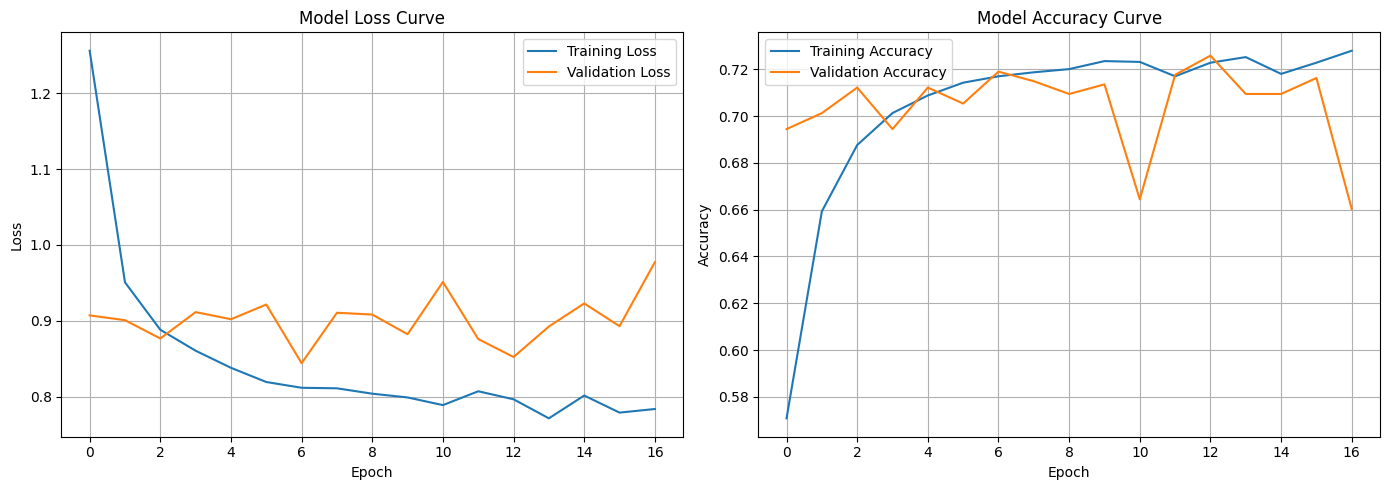


[STEP 6] Learning curves displayed. Analyze them for overfitting/underfitting.


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt # 학습 곡선 시각화용

# --- STEP 6: 베이스라인 모델 구축 및 초기 학습 ---

print("\n[STEP 6] Building and Training Baseline Model...")

# 6-1. 딥러닝 모델 아키텍처 정의 (간단한 CNN 모델)
# Sequential 모델은 층을 순서대로 쌓아 올리는 가장 간단한 모델입니다.
model = Sequential([
    # 첫 번째 Convolutional 층:
    # 32개의 필터(커널), 각 3x3 크기.
    # 'relu' (Rectified Linear Unit) 활성화 함수 사용.
    # input_shape: 모델이 받을 이미지의 형태 (높이, 너비, 채널).
    # 우리가 이전에 설정한 IMG_HEIGHT, IMG_WIDTH, 그리고 컬러 이미지이므로 3채널을 사용합니다.
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # MaxPooling 층:
    # (2, 2) 크기의 풀링 윈도우를 사용하여 특징 맵의 크기를 줄이고 중요한 특징을 추출합니다.
    MaxPooling2D((2, 2)),

    # 두 번째 Convolutional 층: 필터 수를 64개로 늘림
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 세 번째 Convolutional 층: 필터 수를 128개로 늘림
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten 층:
    # 2D 특징 맵(피쳐 맵)을 1D 벡터로 평탄화하여 완전 연결(Dense) 층에 전달할 준비를 합니다.
    Flatten(),

    # 완전 연결(Dense) 층:
    # 512개의 뉴런을 가진 은닉층. 'relu' 활성화 함수 사용.
    Dense(512, activation='relu'),
    # Dropout 층:
    # 과적합(Overfitting) 방지를 위해 50%의 뉴런을 랜덤하게 비활성화합니다.
    Dropout(0.5),

    # 최종 출력 층:
    # NUM_CLASSES (5개)만큼의 뉴런.
    # 'softmax' 활성화 함수를 사용하여 각 클래스에 속할 확률을 출력합니다.
    # (클래스 분류 문제에서 다중 클래스일 경우 'softmax' 사용)
    Dense(NUM_CLASSES, activation='softmax')
])

# 모델의 구조를 요약하여 출력합니다. (각 층의 이름, 출력 형태, 파라미터 수 확인)
model.summary()

# 6-2. 모델 컴파일
# 모델 학습 방법을 설정합니다.
model.compile(
    optimizer='adam',             # 옵티마이저: Adam (Adaptive Moment Estimation)은 성능이 좋고 널리 사용됩니다.
                                  #           학습률(learning rate)도 여기서 조정할 수 있습니다.
    loss='categorical_crossentropy', # 손실 함수: 다중 클래스 분류 문제에서 원-핫 인코딩된 레이블에 사용됩니다.
    metrics=['accuracy']          # 평가 지표: 학습 중 및 평가 시 정확도(accuracy)를 모니터링합니다.
)


# 6-3. 모델 학습
# 학습 과정 모니터링 및 최적 모델 저장을 위한 콜백(Callbacks) 설정

# EarlyStopping:
# 'val_loss' (검증 손실)를 모니터링하여,
# 'patience=10' 에포크 동안 개선이 없으면 학습을 조기 중단합니다.
# 'restore_best_weights=True'는 학습 중 검증 손실이 가장 낮았던 시점의 모델 가중치로 복원합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# ModelCheckpoint:
# 'val_loss'를 모니터링하여,
# 'save_best_only=True'는 검증 손실이 가장 낮은(최고의 성능을 보인) 모델의 가중치를 파일로 저장합니다.
# 'best_dr_model.h5' 파일에 저장됩니다.
model_checkpoint = ModelCheckpoint('best_dr_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# 배치 크기 설정 (한 번에 모델에 주입되는 이미지의 개수)
BATCH_SIZE = 32 # 하드웨어 성능과 데이터셋 크기에 따라 조절 가능
EPOCHS = 100    # 최대 에포크 수 (EarlyStopping에 의해 실제 학습 에포크는 더 짧을 수 있습니다.)

print(f"\n[STEP 6] Starting Model Training with Batch Size: {BATCH_SIZE}, Max Epochs: {EPOCHS}...")
print(f"Monitoring 'val_loss' for Early Stopping (Patience: {early_stopping.patience}) and Model Checkpointing.")

# model.fit() 함수를 사용하여 모델 학습 시작
# train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE) :
#   데이터 증강이 적용된 학습 데이터를 배치 단위로 모델에 공급합니다.
# validation_data=(X_val, y_val) :
#   학습 중 매 에포크마다 모델 성능을 검증하는 데 사용되는 데이터입니다. (증강 없음)
# callbacks :
#   위에서 정의한 EarlyStopping과 ModelCheckpoint 콜백을 적용합니다.
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1 # 학습 진행 상황을 자세히 출력
)
print("[STEP 6] Model Training Finished.")

# 6-4. 학습 곡선 시각화 및 과적합 확인
# 학습이 완료된 후, 모델의 손실(Loss)과 정확도(Accuracy) 변화를 그래프로 시각화합니다.
# 이를 통해 모델의 학습 진행 상황과 과적합 여부를 직관적으로 파악할 수 있습니다.
plt.figure(figsize=(14, 5))

# 손실(Loss) 그래프
plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) # 그리드 표시

# 정확도(Accuracy) 그래프
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) # 그리드 표시

plt.tight_layout() # 플롯 간 간격 자동 조절
plt.show()

print("\n[STEP 6] Learning curves displayed. Analyze them for overfitting/underfitting.")